# This is to test how Rvar varies with length of lightcurve

In [494]:
%matplotlib inline

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from HeaderP import *
plt.rcParams.keys()
plt.rc('font', family='serif')
params = {
   'axes.labelsize': 30,
   'axes.linewidth': 1.5,
   'legend.fontsize': 25,
   'legend.frameon': False,
   'lines.linewidth': 2,
   'xtick.direction': 'in',
   'xtick.labelsize': 25,
   'xtick.major.bottom': True,
   'xtick.major.pad': 10,
   'xtick.major.size': 10,
   'xtick.major.width': 1,
   'xtick.minor.bottom': True,
   'xtick.minor.pad': 3.5,
   'xtick.minor.size': 5,
   'xtick.minor.top': True,
   'xtick.minor.visible': True,
   'xtick.minor.width': 1,
   'xtick.top': True,
   'ytick.direction': 'in',
   'ytick.labelsize': 25,
   'ytick.major.pad': 10,
   'ytick.major.size': 10,
   'ytick.major.width': 1,
   'ytick.minor.pad': 3.5,
   'ytick.minor.size': 5,
   'ytick.minor.visible': True,
   'ytick.minor.width': 1,
   'ytick.right': True,
   'figure.figsize': [10,10], # instead of 4.5, 4.5
   'savefig.format': 'eps',
   'text.usetex': False,
   }
plt.rcParams.update(params)

In [566]:
from astropy import units as u
from astropy.coordinates import SkyCoord
import astropy.utils as au
from astropy.io import fits

# read in McQuillian stars
McQS = pd.read_table('https://arxiv.org/src/1402.5694v2/anc/Table_1_Periodic.txt',delimiter=',',skiprows=1,names=('KID','Teff','logg','Mass','Prot','Prot_err','Rper','LPH','w','DC','Flag'))
print('McQuillian',np.shape(McQS))

# gaia data from https://gaia-kepler.fun/
with fits.open('kepler_dr2_1arcsec.fits') as data_ga:
    gaia = pd.DataFrame(data_ga[1].data, dtype="float64")
#print(gaia)

# merge two tables with same KID
df = pd.merge(McQS, gaia, left_on="KID", right_on="kepid", how="inner")
#print(df)

# drop duplicates
df.drop_duplicates(subset ="KID", keep = False, inplace = True) 
print('Cross-matched',np.shape(df))
print('Missing %d stars'%(np.shape(McQS)[0]-np.shape(df)[0]))

McQuillian (34030, 11)
Cross-matched (32984, 145)
Missing 1046 stars


Code to read lightcurves from Ruth https://github.com/RuthAngus/amped/blob/master/code/kepler_data.py

In [3]:
from __future__ import print_function
import glob
import os
from tqdm import trange
def load_and_join(LC_DIR):
    """
    load and join quarters together.
    Takes a list of fits file names for a given star.
    Returns the concatenated arrays of time, flux and flux_err
    """
    fnames = sorted(glob.glob(os.path.join(LC_DIR, "*fits")))
    #print(fnames)
    hdulist = fits.open(fnames[0])
    t = hdulist[1].data
    time = t["TIME"]
    flux = t["PDCSAP_FLUX"]
    flux_err = t["PDCSAP_FLUX_ERR"]
    q = t["SAP_QUALITY"]
    m = np.isfinite(time) * np.isfinite(flux) * np.isfinite(flux_err) * \
            (q == 0)
    x = time[m]
    med = np.median(flux[m])
    y = flux[m]/med - 1
    yerr = flux_err[m]/med
    for fname in fnames[1:]:
       hdulist = fits.open(fname)
       t = hdulist[1].data
       time = t["TIME"]
       flux = t["PDCSAP_FLUX"]
       flux_err = t["PDCSAP_FLUX_ERR"]
       q = t["SAP_QUALITY"]
       m = np.isfinite(time) * np.isfinite(flux) * np.isfinite(flux_err) * \
               (q == 0)
       x = np.concatenate((x, time[m]))
       med = np.median(flux[m])
       y = np.concatenate((y, flux[m]/med - 1))
       yerr = np.concatenate((yerr, flux_err[m]/med))
    return x, y, yerr

def load_and_split(LC_DIR):
    """
    load individual quarters.
    Takes a list of fits file names for a given star.
    Returns a list of arrays of time, flux and flux_err
    """

    fnames = sorted(glob.glob(os.path.join(LC_DIR, "*fits")))
    time, flux, flux_err = [], [], []
    for i in range(len(fnames)):
        hdulist = fits.open(fnames[i])
        t = hdulist[1].data
        x, y, yerr = t["TIME"], t["PDCSAP_FLUX"], t["PDCSAP_FLUX_ERR"]
        m = np.isfinite(x) * np.isfinite(y) * np.isfinite(yerr) \
                        * (t["SAP_QUALITY"] == 0)

        time.append(x[m])
        med = np.median(y[m])
        flux.append(y[m]/med - 1)
        flux_err.append(yerr[m]/med)

    return time, flux, flux_err

Get lightcurves and saved in ~/.kplr/data/lightcurves/ only run if need more lightcurves!

In [ ]:
import kplr # with pip install needed to change async into async_ for python 3.7...
import random
client = kplr.API()
# pick out # of stars
samplesize=300
KID_a = df.KID.values[random.sample(range(0,len(df.KID)), samplesize)] # list of KID
for KID in KID_a:
    star = client.star(str(KID))
    star.get_light_curves(fetch=True, short_cadence=False)

read in lightcurves and get original data

In [232]:
pathtolightcurves="/Users/lucy/Desktop/FirstYearML/lightcurves/"
dirc = os.listdir(pathtolightcurves)
samplesize=len(dirc)
# initialize all times/flux/flux_err
time=[[] for i in range(samplesize)]
flux=[[] for i in range(samplesize)]
flux_err=[[] for i in range(samplesize)]
KID_sort=np.zeros([samplesize,1])
for i in range(samplesize):
    KID_sort[i]=dirc[i]
    LC_DIR=pathtolightcurves+dirc[i]
    time[i], flux[i], flux_err[i]=load_and_join(LC_DIR)
KID_sort=[int(i) for i in KID_sort]

704.7913877550748
-1057.0273379768314


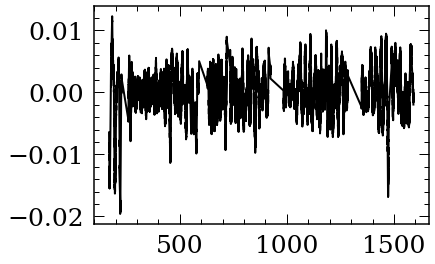

In [251]:
plt.figure()
plt.plot(time[160], flux[160],'k-')
print(len(time[150])/(max(time[150])-min(time[150]))*27*0.8)
print(27/(time[150][0]-time[150][1])*0.8)

In [234]:
# save file 
"""
np.save('time',time)
np.save('flux',flux)
np.save('flux_err',flux_err)
"""
# save np.load
np_load_old = np.load

# modify the default parameters of np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

# load file
time=np.load('time.npy')
flux=np.load('flux.npy')
flux_err=np.load('flux_err.npy')
#print(flux)
np.load = np_load_old

pathtolightcurves="/Users/lucy/Desktop/FirstYearML/lightcurves/"
dirc = os.listdir(pathtolightcurves)
samplesize=len(dirc)
KID_sort=np.zeros([samplesize,1])
for i in range(samplesize):
    KID_sort[i]=dirc[i]
KID_sort=[int(i) for i in KID_sort]

In [228]:
import timeit
print('Time for using i directly from flux:', timeit.timeit(lambda:[(np.percentile(i,95)-np.percentile(i,5)) for i in flux], number=5000))
print('Time for using i from indexing:', timeit.timeit(lambda:[(np.percentile(flux[i],95)-np.percentile(flux[i],5)) for i in range(len(flux))], number=5000))

Time for using i direction from flux: 1838.0821487610083
Time for using i from indexing: 1836.4939223110123


## covariance between Rper and Rvar

/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/Users/lucy/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/lucy/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a

covariance matrix: 
 [[1.30133195e+08 1.49989224e+02]
 [1.49989224e+02 1.79247748e-04]]


'\nimport corner\n# plot corner plot\nsample=np.zeros([len(Rvar),2])\nsample[:,0]=Rper\nsample[:,1]=Rvar\nfigure=corner.corner(sample,labels=["Rper", "Rvar"],quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 12})\nplt.tight_layout()\n'

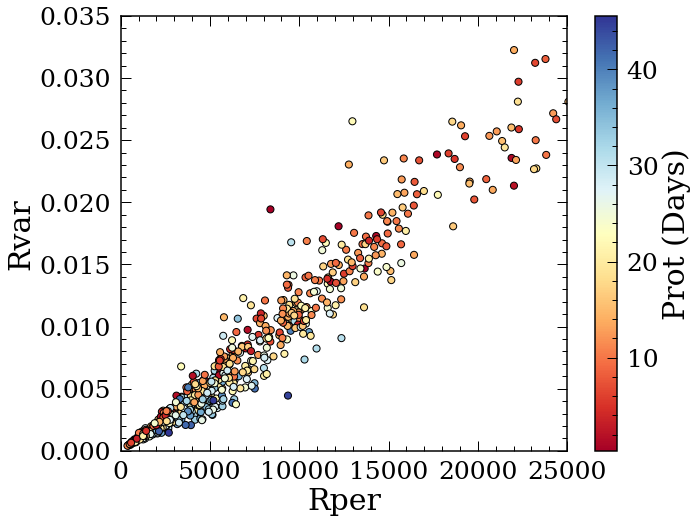

In [235]:
# get rotation periods and Rper of these stars (must be a easier way...)
df_wlc=df.loc[df['KID'].isin(KID_sort)]
sorterIndex = dict(zip(KID_sort,range(len(KID_sort))))
df_wlc['KID_Rank'] = df['KID'].map(sorterIndex)
df_wlc.sort_values(['KID_Rank'], ascending = True, inplace = True)
df_wlc.drop('KID_Rank', 1, inplace = True)
df_wlc=df_wlc.reset_index(drop=True)

Prot=df_wlc.Prot.values
Rper=df_wlc.Rper.values

# get Rvar from np.percentile(flux,95)-np.percentile(flux,5)
def getRvar(Flux):
    return abs(np.percentile(Flux,95)-np.percentile(Flux,5))

Rvar=[getRvar(i) for i in flux]
df_wlc['Rvar']=Rvar
plt.figure(figsize=(10,8))
cm = plt.cm.get_cmap('RdYlBu')
plt.scatter(Rper,Rvar,c=Prot,s=50, cmap=cm,edgecolors='k')
cb=plt.colorbar()
cb.set_label('Prot (Days)')
plt.ylabel('Rvar')
plt.xlabel('Rper')
plt.xlim([0,25000])
plt.ylim([0,0.035])

#print(np.shape(np.squeeze(Rper)),np.shape(Rvar))
print('covariance matrix: \n',np.cov(np.squeeze(Rper),Rvar))

'''
import corner
# plot corner plot
sample=np.zeros([len(Rvar),2])
sample[:,0]=Rper
sample[:,1]=Rvar
figure=corner.corner(sample,labels=["Rper", "Rvar"],quantiles=[0.16, 0.5, 0.84],show_titles=True, title_kwargs={"fontsize": 12})
plt.tight_layout()
'''

## Cut into 27 days

In [254]:
#print(len(time[0]/(max(time[0])-min(time[0])))) # points/day should have at lease this much points per day...
import random
import pandas as pd
def cut_lc(Time,Flux,Fluxerr,days): # cut out a random section of data
    #print(np.shape(Time))
    # days: how many days to cut the lightcurves into
    ####### might want to make better constrain here for what's the min point #######
    minpoints=len(Time)/(max(Time)-min(Time))*days*0.8 # min number of points to accept the cut
    startT=random.choice(Time)
    endT=startT+days
    # put these into dataframe
    data=np.array((Time,Flux,Fluxerr)).T
    columns=['Time','Flux','Flux_err']
    df=pd.DataFrame(data,columns=columns) 
    sel_df=df.loc[(df['Time']>=startT) & (df['Time']<=endT)] # get selected data
    # regenerate cut if too short
    while len(sel_df.Time)<minpoints:
        startT=random.choice(Time) # chose a random time to start
        endT=startT+days 
        sel_df=df.loc[(df['Time']>=startT) & (df['Time']<=endT)] # get selected data
    return sel_df

# Get Rvar_27 for each lightcurve for 20 times

In [256]:
############ Do not run unless have new data!!! ######################
TestT=20 # how many times to cut the lightcurve to test
Rvar_27=np.zeros([len(time),TestT]) # Rvar for each lightcurve
for i in range(len(Prot)):
    update_progress(i / len(Prot))
    for j in range(TestT):
        sel_df=cut_lc(time[i],flux[i],flux_err[i],27.)
        Rvar_27[i,j]=getRvar(sel_df.Flux)
############ Do not run unless have new data!!! ######################

Progress: [####################] 99.8%


Plot error in Rvar_27 respect to Rvar

-1.1475265182525618e-12
Mostly underestimated Rvar


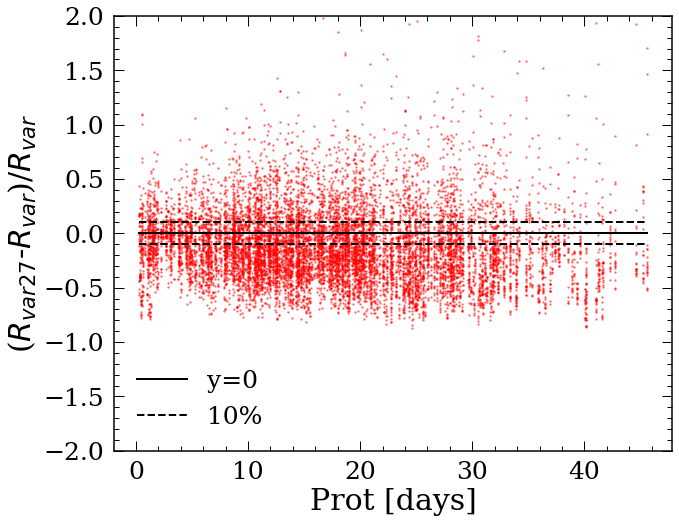

In [257]:
#np.save('Rvar_27',Rvar_27)
Rvar_27=np.load('Rvar_27.npy')
import random
# get mean and std for each Prot
meand=np.zeros(len(Prot))
stdd=np.zeros(len(Prot))
# get rand Rvar_27 to test for RF
Rvar_27_rand=np.zeros(len(Prot))
for i in range(len(Prot)):
    meand[i]=np.mean(Rvar_27[i,:]-Rvar[i])
    stdd[i]=np.std(Rvar_27[i,:]-Rvar[i])
    Rvar_27_rand[i]=random.choice(Rvar_27[i,:]) # get a random element...

# plots
plt.figure(figsize=(10,8))
for i in range(len(Prot)):
    plt.plot(np.ones([TestT,1])*Prot[i],(Rvar_27[i,:]-Rvar[i])/Rvar[i],'r.',markersize=3,alpha=0.4)
sortProt,sortMean,sortStd=zip(*sorted(zip(Prot,meand,stdd)))

df_wlc.sort_values(by=['Prot'])
print(sum(df_wlc['Prot']-sortProt)) # this should be 0
df_wlc['Rvar_27']=Rvar_27_rand

plt.plot(sortProt,np.zeros(len(sortProt)),'k-',label='y=0')
plt.plot(sortProt,np.ones(len(sortProt))*0.1,'k--',label='10%')
plt.plot(sortProt,-np.ones(len(sortProt))*0.1,'k--')
plt.ylim([-2,2])
plt.legend()
plt.xlabel('Prot [days]')
plt.ylabel('($R_{var27}$-$R_{var}$)/$R_{var}$')
print('Mostly underestimated Rvar')

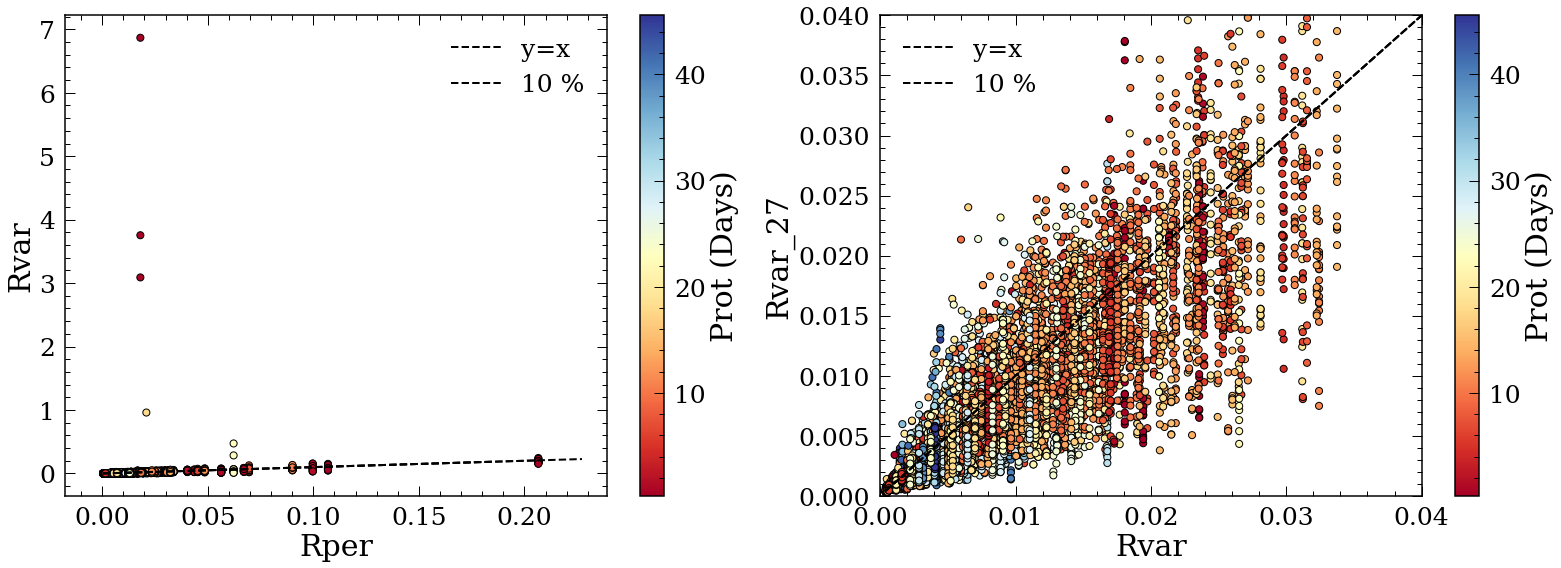

In [258]:
plt.figure(figsize=(22,8))
plt.subplot(1,2,1)
# get everything into 1d array
Rvar_27_ar=Rvar_27.ravel()
Rvar_ar=np.zeros(len(Rvar_27_ar))
Prot_ar=np.zeros(len(Rvar_27_ar))
for i in range(len(Prot)):
    Rvar_ar[i*20:i*20+20]=np.ones(TestT)*Rvar[i]
    Prot_ar[i*20:i*20+20]=np.ones(TestT)*Prot[i]
plt.scatter(Rvar_ar,Rvar_27_ar,c=Prot_ar,s=50, cmap=cm,edgecolors='k')
plt.plot(sorted(Rvar_ar),sorted(Rvar_ar),'k--',label='y=x')
plt.plot(sorted(Rvar_ar+0.1*Rvar_ar),sorted(Rvar_ar+0.1*Rvar_ar),'k--',label='10 %')
plt.plot(sorted(Rvar_ar-0.1*Rvar_ar),sorted(Rvar_ar-0.1*Rvar_ar),'k--')
plt.legend()
cb=plt.colorbar()
cb.set_label('Prot (Days)')
plt.ylabel('Rvar')
plt.xlabel('Rper')


# plotting same thing but zoomed in
plt.subplot(1,2,2)
# get everything into 1d array
Rvar_27_ar=Rvar_27.ravel()
Rvar_ar=np.zeros(len(Rvar_27_ar))
Prot_ar=np.zeros(len(Rvar_27_ar))
for i in range(len(Prot)):
    Rvar_ar[i*20:i*20+20]=np.ones(TestT)*Rvar[i]
    Prot_ar[i*20:i*20+20]=np.ones(TestT)*Prot[i]
plt.scatter(Rvar_ar,Rvar_27_ar,c=Prot_ar,s=50, cmap=cm,edgecolors='k')
plt.plot(sorted(Rvar_ar),sorted(Rvar_ar),'k--',label='y=x')
plt.plot(sorted(Rvar_ar+0.1*Rvar_ar),sorted(Rvar_ar+0.1*Rvar_ar),'k--',label='10 %')
plt.plot(sorted(Rvar_ar-0.1*Rvar_ar),sorted(Rvar_ar-0.1*Rvar_ar),'k--')
plt.legend()
cb=plt.colorbar()
cb.set_label('Prot (Days)')
plt.ylim([0,0.04])
plt.xlim([0,0.04])
plt.ylabel('Rvar_27')
plt.xlabel('Rvar')

plt.tight_layout()




# Train on Rvar_27

Text(0, 0.5, 'Rvar_27')

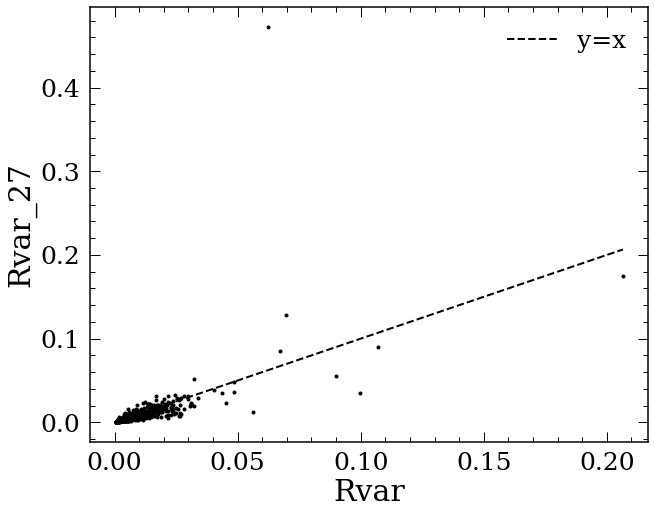

In [261]:
# plot Rvar vs selected Rvar27
plt.figure(figsize=(10,8))
plt.plot(df_wlc['Rvar'],df_wlc['Rvar_27'],'ko',markersize=3)
plt.plot(sorted(df_wlc['Rvar']),sorted(df_wlc['Rvar']),'k--',label='y=x')
plt.legend()
plt.xlabel('Rvar')
plt.ylabel('Rvar_27')

regr,importance,actrualF,predictp,X_test,y_test,y_test_err,avstedv = my_randF_SL(df,traind,testF,chisq_out=0)

Fraction of data used to train: 0.8
# Features used to train: 9
Features used to train: ['Rper' 'teff' 'bp_g' 'lum_val' 'v_tan' 'phot_g_mean_flux_over_error'
 'v_b' 'radius_val' 'b']
632 stars in dataframe!
Missing 46 stars from null values in data!

586 total stars used for RF!
468 training stars!
Average Chisq is: [1042.24045302]
Finished!
average chisq is:  [1042.24045302]


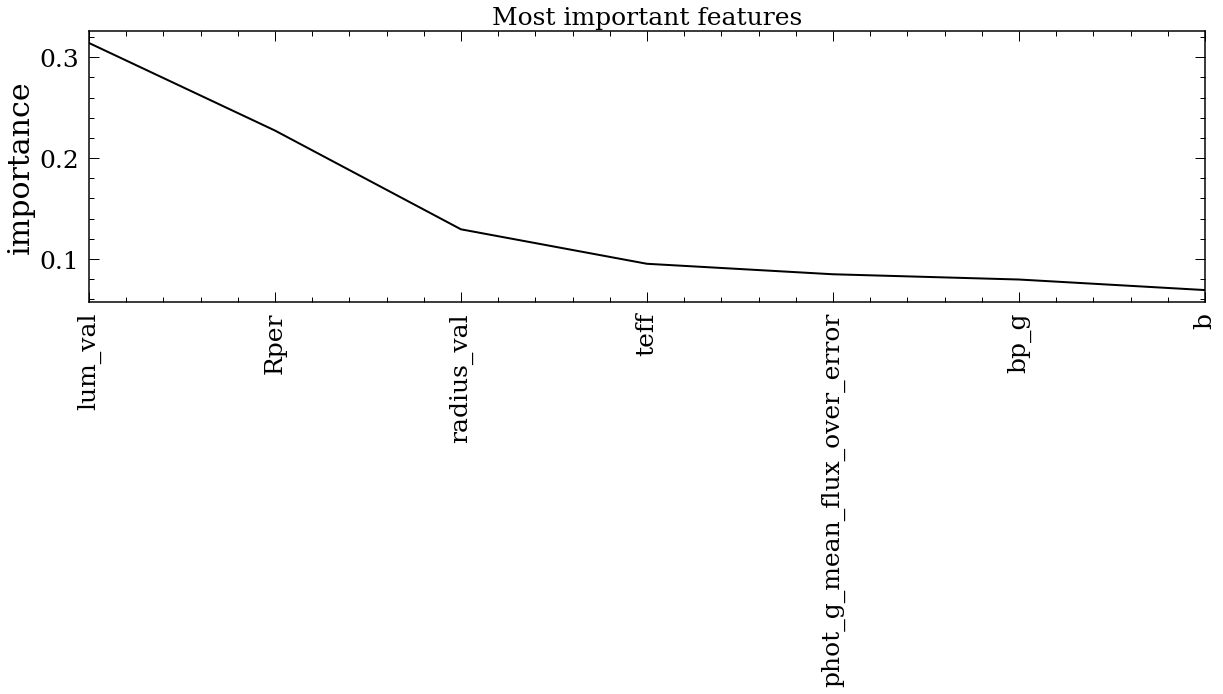

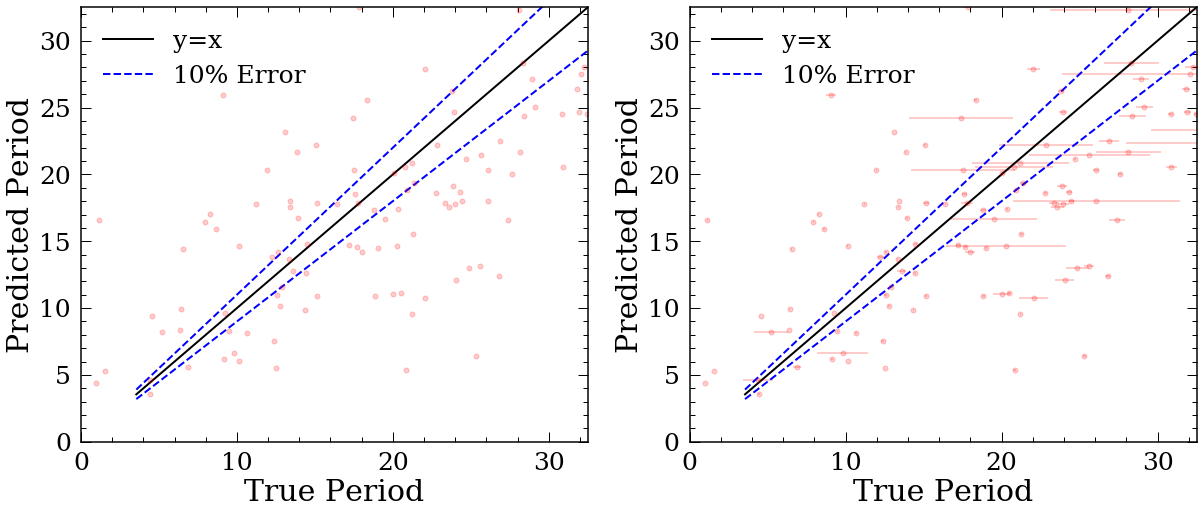

In [270]:
TrainF=np.load('TrainingFeatures.npy')
df_wlc=df_wlc.reset_index(drop=True)
regr,importance,actrualF,KID_train,KID_test,predictp,avstedv=my_randF_SL(df_wlc,0.8,TrainF)
y_test=df_wlc.loc[df_wlc['KID'].isin(KID_test)].Prot.values
y_test_err=df_wlc.loc[df_wlc['KID'].isin(KID_test)].Prot_err.values
my_xticks=plot_result(actrualF,importance,predictp,y_test,y_test_err)

regr,importance,actrualF,predictp,X_test,y_test,y_test_err,avstedv = my_randF_SL(df,traind,testF,chisq_out=0)

Fraction of data used to train: 0.8
# Features used to train: 9
Features used to train: ['teff', 'bp_g', 'lum_val', 'v_tan', 'phot_g_mean_flux_over_error', 'v_b', 'radius_val', 'b', 'Rvar_27']
632 stars in dataframe!
Missing 46 stars from null values in data!

586 total stars used for RF!
468 training stars!
Average Chisq is: [1676.41348605]
Finished!
average chisq is:  [1676.41348605]


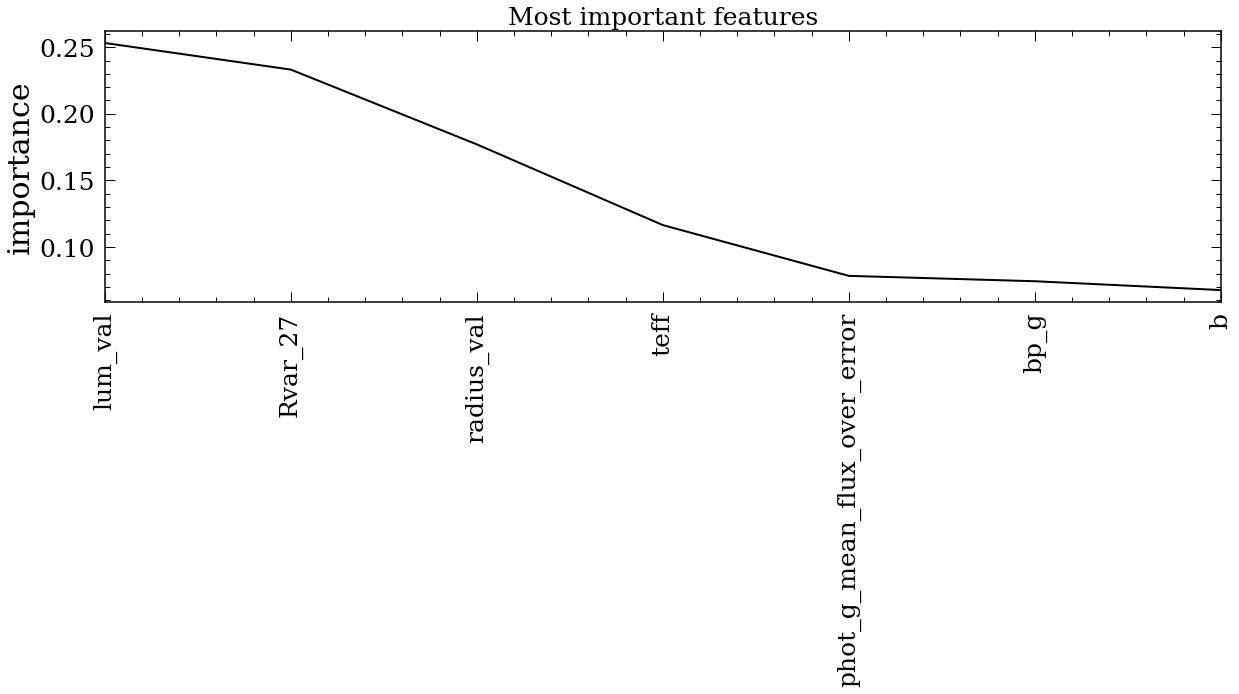

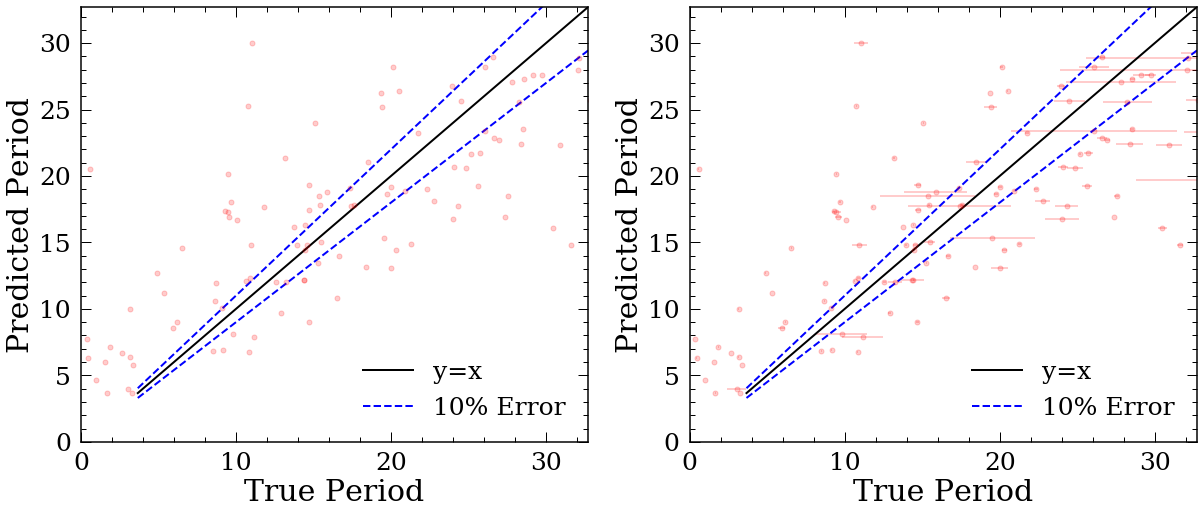

In [271]:
TrainF=np.load('TrainingFeatures.npy')
TrainF=[i for i in TrainF if i!='Rper']
TrainF.append('Rvar_27')
df_wlc=df_wlc.reset_index(drop=True)
regr,importance,actrualF,KID_train,KID_test,predictp,avstedv=my_randF_SL(df_wlc,0.8,TrainF)
y_test=df_wlc.loc[df_wlc['KID'].isin(KID_test)].Prot.values
y_test_err=df_wlc.loc[df_wlc['KID'].isin(KID_test)].Prot_err.values
my_xticks=plot_result(actrualF,importance,predictp,y_test,y_test_err)

# Get Power spectrum 

functions to get power spectrum

In [264]:
from scipy import signal
from astropy import units as u
############### function to pass the lc through high pass filter of 20 days and 80 days ###############
def hp_spec(t,sig,plotP=False):
    '''
    ### inputs:
    # t: Time array [days]
    # sig: Flux array
    # plotP: plot lightcurves or not
    ### outputs:
    # sig_20,sig_80: flux signal after using 20 days and 80 days high-pass filter
    '''
    # 20 days to rad/s
    hp20=20 * u.day
    hp20=hp20.to(u.second)  
    hp20=1./hp20
    #print(hp20.value*1e6,'mu Hz')

    # 80 days to rad/s
    hp80=80 * u.day
    hp80=hp80.to(u.second)  
    hp80=1./hp80
    #print(hp80.value*1e6,'mu Hz')

    # convert time to seconds
    t = (t*u.day).to(u.second).value

    # define butterfilter for 20 days
    sos_20 = signal.butter(100, hp20, 'highpass', fs=(max(t)-min(t))/len(t), output='sos')
    sig_20 = signal.sosfilt(sos_20, sig)

    # define butterfilter for 80 days
    sos_80 = signal.butter(100, hp80, 'highpass', fs=(max(t)-min(t))/len(t), output='sos')
    sig_80 = signal.sosfilt(sos_80, sig)

    """
    plt.figure(figsize=(15,4))
    plt.plot(sig_20-sig_80,'k-',label='sig_20-sig_80')
    plt.ylabel('$\Delta$Flux')
    plt.xlabel('Time [days]')
    plt.legend()
    """
    if plotP:
        plt.figure(figsize=(20,15)) 
        plt.subplot(3, 1, 1)
        t=(t*u.second).to(u.day).value
        plt.plot(t-min(t), sig,'k-',label='Original lc')
        plt.ylabel('Flux')
        plt.legend()
        plt.subplot(3, 1, 2)
        plt.plot(t-min(t), sig_20,'k-',label='20 day high-pass')
        plt.ylabel('Flux')
        plt.legend()
        plt.subplot(3, 1, 3)
        plt.plot(t-min(t), sig_80,'k-',label='80 day high-pass')
        plt.ylabel('Flux')
        plt.xlabel('Time [days]')
        plt.legend()
    return sig_20,sig_80


from astropy.timeseries import LombScargle
import astropy.units as u
def getPspec(t,sig,sig_err,plotP=False):
    '''
    ### inputs:
    # t: Time array [days]
    # sig: Flux array
    # sig_err: Flux error array
    # plotP: plot powerspectrum or not
    ### outputs:
    # np.column_stack((freqs_20,power_20)),np.column_stack((freqs_80,power_80)): powerspectrum for hp 20 and hp 80 days
    '''
    
    t_days = t
    dy = sig_err

    # lc passed by high-pass filter 20, 80 days
    sig_20,sig_80=hp_spec(t,sig)
    
    # lomb-scargle
    #### define frequency use to analyze
    nfreq=50000 # how many points in frequency space
    maxtime=max(t) # max time
    mintime=min(t) # min time

    tstep=abs(t[1]-t[0]) # timestep

    freqmax=1/tstep*0.5 # def max frequency
    freqmin_20 = 0.00001 # def min frequency for 20 day hp filter
    freqmin_80 = 0.00001 # def min frequency for 20 day hp filter
    #freqmin_20 = 1/(20.) # def min frequency for 20 day hp filter
    #freqmin_80 = 1/(80.) # def min frequency for 20 day hp filter

    freqstep_20 = (freqmax-freqmin_20)/nfreq # def frequency spacing for 20 day hp
    freqstep_80 = (freqmax-freqmin_80)/nfreq # def frequency spacing for 80 day hp

    freqs_20 = [freqmin_20+i*freqstep_20 for i in range(nfreq)] # def frequency array for 20 day hp
    freqs_80 = [freqmin_80+i*freqstep_80 for i in range(nfreq)] # def frequency array for 80 day hp

    # get the power from lombscargle (weighted from astropy)
    power_20 = LombScargle(np.asarray(t_days), np.asarray(sig_20),dy).power(np.asarray(freqs_20))
    power_80 = LombScargle(np.asarray(t_days), np.asarray(sig_80),dy).power(np.asarray(freqs_80))

    # convert frequencies to muHz
    freqs_20=np.asarray(freqs_20)*(1./u.day.to(u.second)*1e6)
    freqs_80=np.asarray(freqs_80)*(1./u.day.to(u.second)*1e6)
    if plotP:
        plt.figure(figsize=(15,8))
        plt.subplot(2,1,1)
        plt.loglog(np.asarray(freqs_20), power_20,'k-',label='PS after 20 day hp')
        plt.plot([1/(20.),1/(20.)],[0,max(power_20)],'r--',label='20 day')
        plt.xlim([0.01,300])
        plt.ylabel('20 day hp')
        plt.legend()

        plt.subplot(2,1,2)
        plt.loglog(np.asarray(freqs_80), power_80,'k-',label='PS after 80 day hp')
        plt.plot([1/(80.),1/(80.)],[0,max(power_80)],'r--',label='80 day')
        plt.xlabel('Frequency [$\mu$Hz]')
        plt.xlim([0.01,300])
        plt.ylabel('80 day hp')
        plt.legend()
    
    return np.column_stack((freqs_20,power_20)),np.column_stack((freqs_80,power_80))

# See if we can recover spectrum from FliPer paper

get stars from Fliper paper

In [102]:
import kplr # with pip install needed to change async into async_ for python 3.7...
import random
client = kplr.API()
KID_paper=['10709834','8298090','5215508','1723656']
for KID in KID_paper:
    star = client.star(str(KID))
    star.get_light_curves(fetch=True, short_cadence=False)

Read in lc's

In [106]:
pathtolightcurves="/Users/lucy/Desktop/FirstYearML/lightcurves_paper/"
dirc = os.listdir(pathtolightcurves)
samplesize=len(KID_paper)
# initialize all times/flux/flux_err
time_paper=[[] for i in range(samplesize)]
flux_paper=[[] for i in range(samplesize)]
flux_err_paper=[[] for i in range(samplesize)]
KID_sort_paper=np.zeros([samplesize,1])
for i in range(samplesize):
    KID_sort_paper[i]=dirc[i]
    LC_DIR=pathtolightcurves+dirc[i]
    time_paper[i], flux_paper[i], flux_err_paper[i]=load_and_join(LC_DIR)
KID_sort_paper=[int(i) for i in KID_sort_paper]

In [114]:
gaia_data=gaia.loc[gaia['kepid'].isin(KID_sort_paper)][['kepid','kmag','teff','teff_err1']]
print(gaia_data)

             kepid    kmag    teff  teff_err1
793      1723656.0  10.320  4777.0       57.0
39269    5215508.0  10.069  6754.0       70.0
107444   8298090.0   9.046  5776.0       69.0
167296  10709834.0   8.788  6623.0       72.0


0.5787037037037037 mu Hz
0.14467592592592593 mu Hz
Does't look that much different after 20d and 80d high-pass filter?


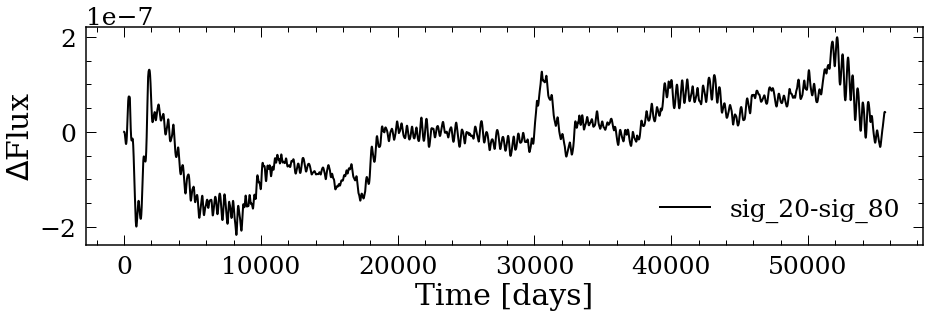

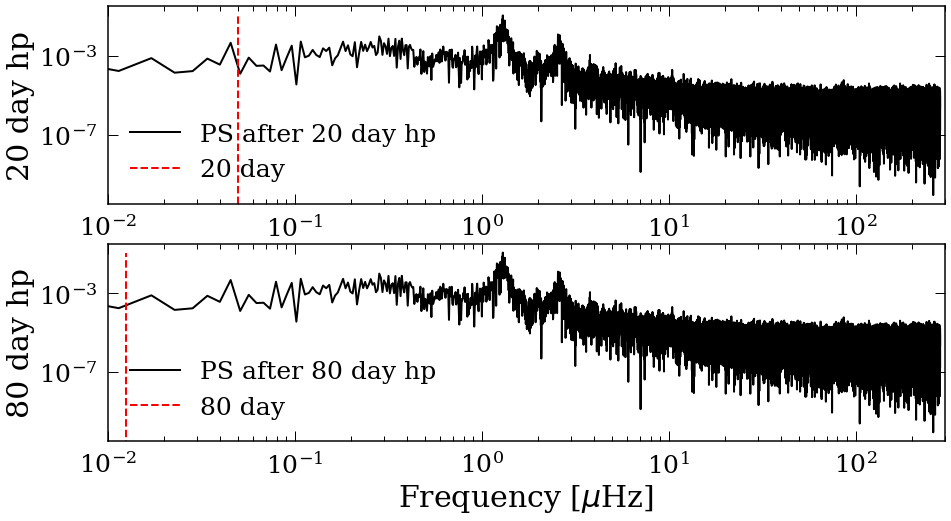

In [190]:
#for i in range(len(KID_sort_paper)):
for i in range(1,2):
    t=time_paper[i]
    sig=flux_paper[i]
    sig_err=flux_err_paper[i]
    star_tab_psd_20,star_tab_psd_80=getPspec(t,sig,sig_err,plotP=True)
print("Does't look that much different after 20d and 80d high-pass filter?")

# Calculate fliper

In [265]:
from FLIPER import *
def CalcF(star_tab_psd_20,star_tab_psd_80,kepmag):
    '''
    star_tab_psd_20=np.column_stack((freqs_20,power_20))
    star_tab_psd_80=np.column_stack((freqs_80,power_80))

    #Give star parameters
    kepmag          =   12.62
    '''
    """
    Calculate FliPer values.
    """
    Fliper_20_d =   FLIPER().Fp_20_days(star_tab_psd_20, kepmag)
    Fliper_80_d =   FLIPER().Fp_80_days(star_tab_psd_80, kepmag)
    Fp02        =   Fliper_80_d.fp02[0]
    Fp07        =   Fliper_20_d.fp07[0]
    Fp7         =   Fliper_20_d.fp7[0]
    Fp20        =   Fliper_20_d.fp20[0]
    Fp50        =   Fliper_20_d.fp50[0]
    return Fp02,Fp07,Fp7,Fp20,Fp50

calculate Flipers for all the lc's

In [266]:
df_wlc['Fp02']=np.zeros(len(KID_sort))
df_wlc['Fp07']=np.zeros(len(KID_sort))
df_wlc['Fp7']=np.zeros(len(KID_sort))
df_wlc['Fp20']=np.zeros(len(KID_sort))
df_wlc['Fp50']=np.zeros(len(KID_sort))
#for i in range(1):
for i in range(len(KID_sort)):
    update_progress(i / len(KID_sort))
    lc_ind=df_wlc.loc[df_wlc['KID']==KID_sort[i]].index
    kmag=df_wlc['kmag'].loc[lc_ind]
    star_tab_psd_20,star_tab_psd_80=getPspec(time[i],flux[i],flux_err[i])
    #print(CalcF(star_tab_psd_20,star_tab_psd_80,kepmag))
    df_wlc['Fp02'][lc_ind],df_wlc['Fp07'][lc_ind],df_wlc['Fp7'][lc_ind],df_wlc['Fp20'][lc_ind],df_wlc['Fp50'][lc_ind]=CalcF(star_tab_psd_20,star_tab_psd_80,kepmag)

Progress: [####################] 99.8%


plot correlations

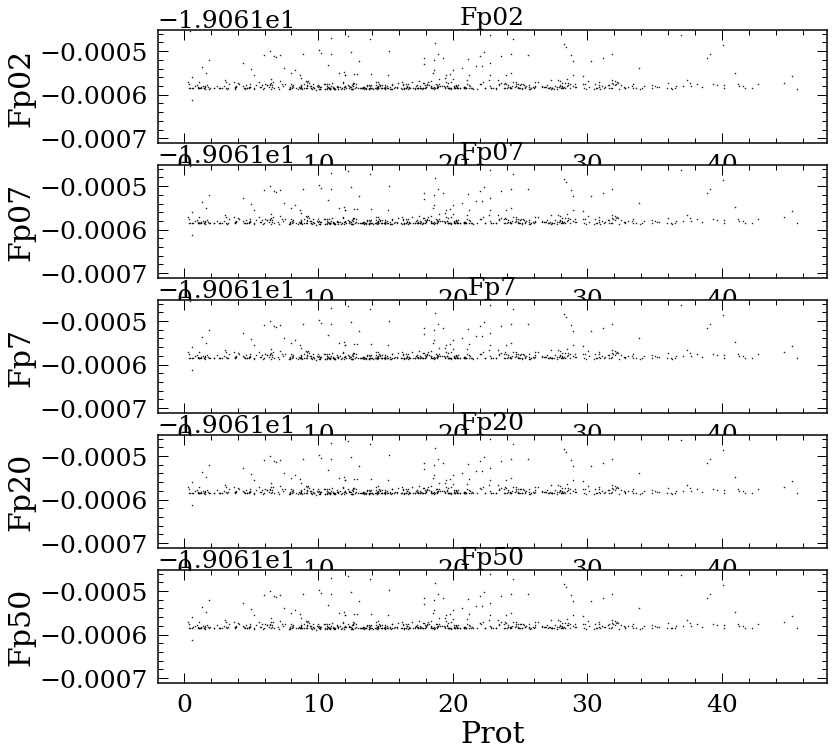

In [281]:
my_xticks=['Fp02','Fp07','Fp7','Fp20','Fp50']
plot_corr(df_wlc,my_xticks)

['teff' 'bp_g' 'lum_val' 'v_tan' 'phot_g_mean_flux_over_error' 'v_b'
 'radius_val' 'b' 'Rvar_27' 'Fp02' 'Fp07' 'Fp7' 'Fp20' 'Fp50']
regr,importance,actrualF,predictp,X_test,y_test,y_test_err,avstedv = my_randF_SL(df,traind,testF,chisq_out=0)

Fraction of data used to train: 0.8
# Features used to train: 14
Features used to train: ['teff' 'bp_g' 'lum_val' 'v_tan' 'phot_g_mean_flux_over_error' 'v_b'
 'radius_val' 'b' 'Rvar_27' 'Fp02' 'Fp07' 'Fp7' 'Fp20' 'Fp50']
632 stars in dataframe!
Missing 46 stars from null values in data!

586 total stars used for RF!
468 training stars!
Average Chisq is: [1186.70862688]
Finished!
average chisq is:  [1186.70862688]


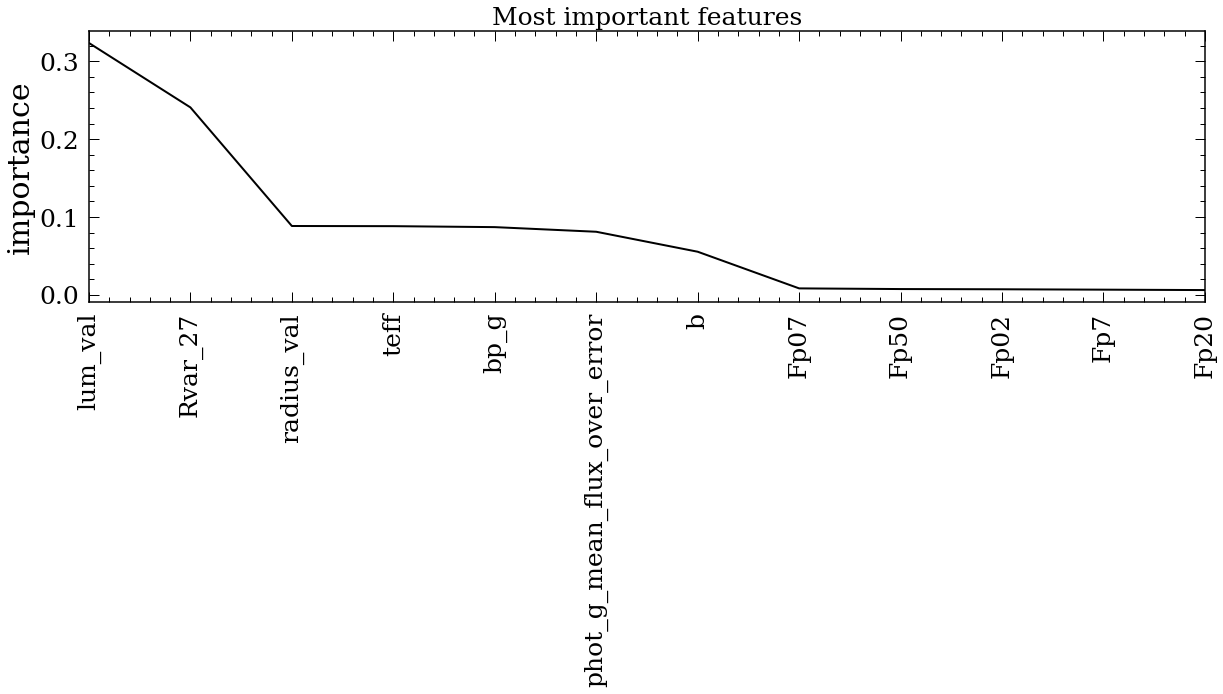

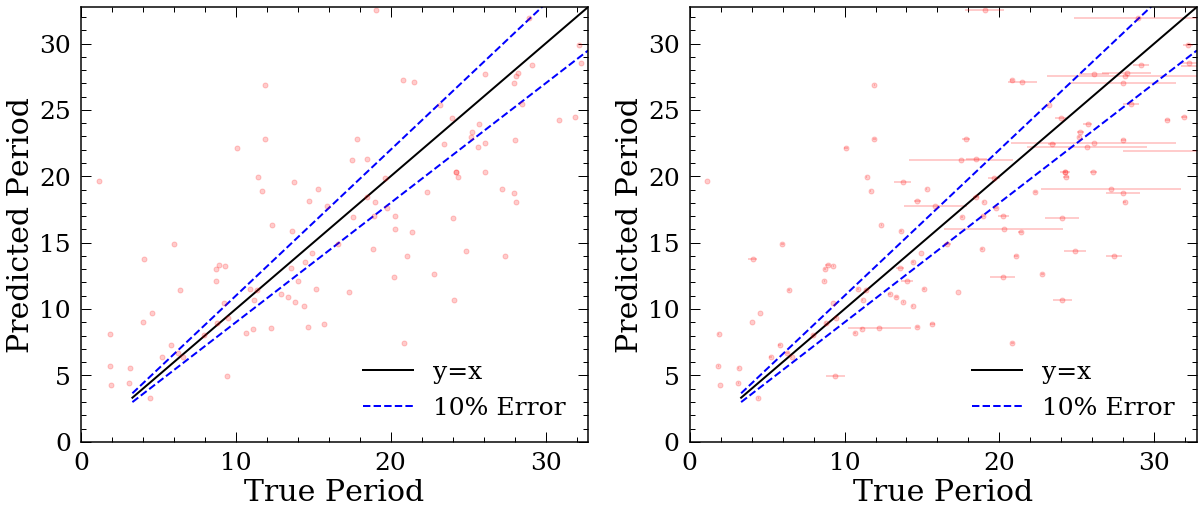

In [519]:
TrainF=np.load('TrainingFeatures.npy')
TrainF=[i for i in TrainF if i!='Rper']
TrainF=np.append(TrainF,['Rvar_27'])
TrainF=np.append(TrainF,['Fp02','Fp07','Fp7','Fp20','Fp50'])
print(TrainF)
df_wlc=df_wlc.reset_index(drop=True)
regr,importance,actrualF,KID_train,KID_test,predictp,avstedv=my_randF_SL(df_wlc,0.8,TrainF)
y_test=df_wlc.loc[df_wlc['KID'].isin(KID_test)].Prot.values
y_test_err=df_wlc.loc[df_wlc['KID'].isin(KID_test)].Prot_err.values
my_xticks=plot_result(actrualF,importance,predictp,y_test,y_test_err)

# Calculate Flicker

In [514]:
from scipy.interpolate import interp1d
def CalcFlicker(flux,time,Kp,KID,points=16):
    # −0.03910−0.67187Kp+0.06839Kp^2−0.001755Kp^3
    logF8_c=-0.03910-0.67187*Kp+0.06839*Kp**2.-0.001755*Kp**3.
    # interpolate between missing points
    flux=flux*1000 # convert to ppt
    flux_int=[]
    time_int=[]
    count=0
    for i in range(len(flux)-1):
        intstep=round((time[i+1]-time[i])/0.020434578240383416)
        if intstep!=1: # if time is missing
            f = interp1d([time[i],time[i+1]], [flux[i],flux[i+1]])
            intstep=int(intstep)-1
            for k in range(intstep):
                flux_int.append(f(time[i]+(k+1)*0.020434578240383416))
                time_int.append(time[i]+(k+1)*0.020434578240383416)
        else:
            flux_int.append(flux[i])
            time_int.append(time[i])
    df=pd.Series(flux_int)
    dftime=pd.Series(time_int)
    medF=df.rolling(points).median()
    plt.figure(figsize=(20,10))
    plt.plot(time_int-min(time_int),flux_int,'k-')
    plt.plot(time_int-min(time),medF,'r-')
    plt.title(str(KID),fontsize=25)
    df2=pd.Series(flux_int-medF)
    df2=df2.dropna()
    
    flicker=np.sqrt(np.mean(np.power(df2,2.)))
    
    return flicker,np.sqrt((flicker)**2-(np.power(10.,logF8_c))**2)

Get lc's from flicker paper (last page table)

In [316]:
import kplr # with pip install needed to change async into async_ for python 3.7...
import random
client = kplr.API()
KID_paper_flic=['5449910','4543923','9657636','8779965','3939679','11083613']
for KID in KID_paper_flic:
    star = client.star(str(KID))
    star.get_light_curves(fetch=True, short_cadence=False)

In [483]:
##################### put lc in arrays (could be a function... too lazy rn) #####################
pathtolightcurves="/Users/lucy/Desktop/FirstYearML/lightcurves_paper_flicker/"
dirc = os.listdir(pathtolightcurves)
samplesize_flic=len(KID_paper_flic)
# initialize all times/flux/flux_err
time_paper_flic=[[] for i in range(samplesize_flic)]
flux_paper_flic=[[] for i in range(samplesize_flic)]
flux_err_paper_flic=[[] for i in range(samplesize_flic)]
KID_sort_paper_flic=np.zeros([samplesize_flic,1])
for i in range(samplesize_flic):
    KID_sort_paper_flic[i]=dirc[i]
    LC_DIR=pathtolightcurves+dirc[i]
    print(LC_DIR)
    time_paper_flic[i], flux_paper_flic[i], flux_err_paper_flic[i]=load_and_split(LC_DIR)
KID_sort_paper_flic=[int(i) for i in KID_sort_paper_flic]
##################### put lc in arrays (could be a function... too lazy rn) #####################

/Users/lucy/Desktop/FirstYearML/lightcurves_paper_flicker/004543923
/Users/lucy/Desktop/FirstYearML/lightcurves_paper_flicker/008779965
/Users/lucy/Desktop/FirstYearML/lightcurves_paper_flicker/011083613
/Users/lucy/Desktop/FirstYearML/lightcurves_paper_flicker/005449910
/Users/lucy/Desktop/FirstYearML/lightcurves_paper_flicker/009657636
/Users/lucy/Desktop/FirstYearML/lightcurves_paper_flicker/003939679


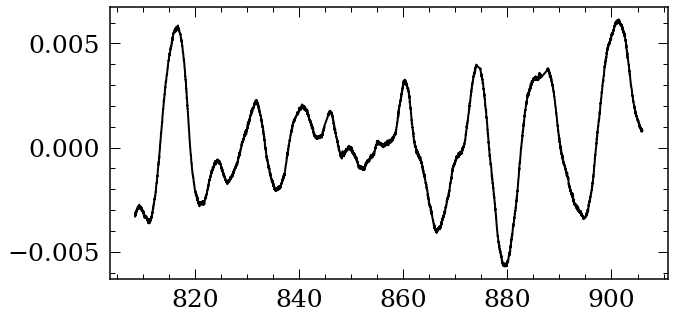

In [518]:
plt.figure(figsize=(10,5))
plt.plot(time_paper_flic[3][8],flux_paper_flic[3][8],'k-')

KID [4543923, 8779965, 11083613, 5449910, 9657636, 3939679]
F_8 [0.0762731  0.0664505  0.3658346  0.21921988 0.03038531 0.17899443]
F_8 from paper [0.055, 0.067, 0.284, 0.046, 0.049, 0.171]
¯\_(ツ)_/¯


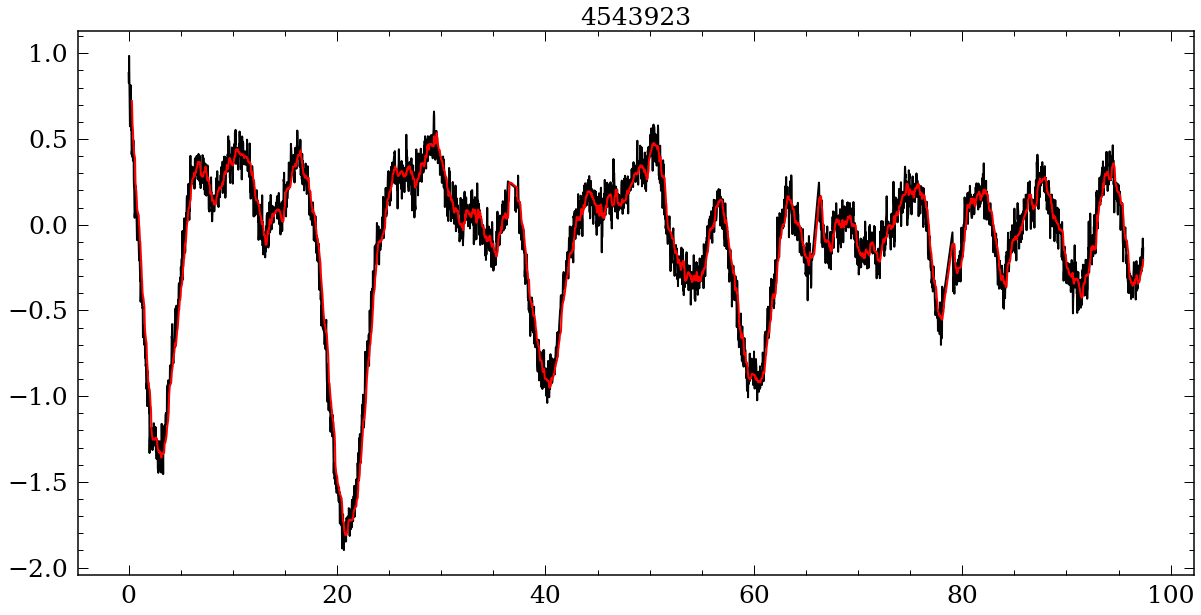

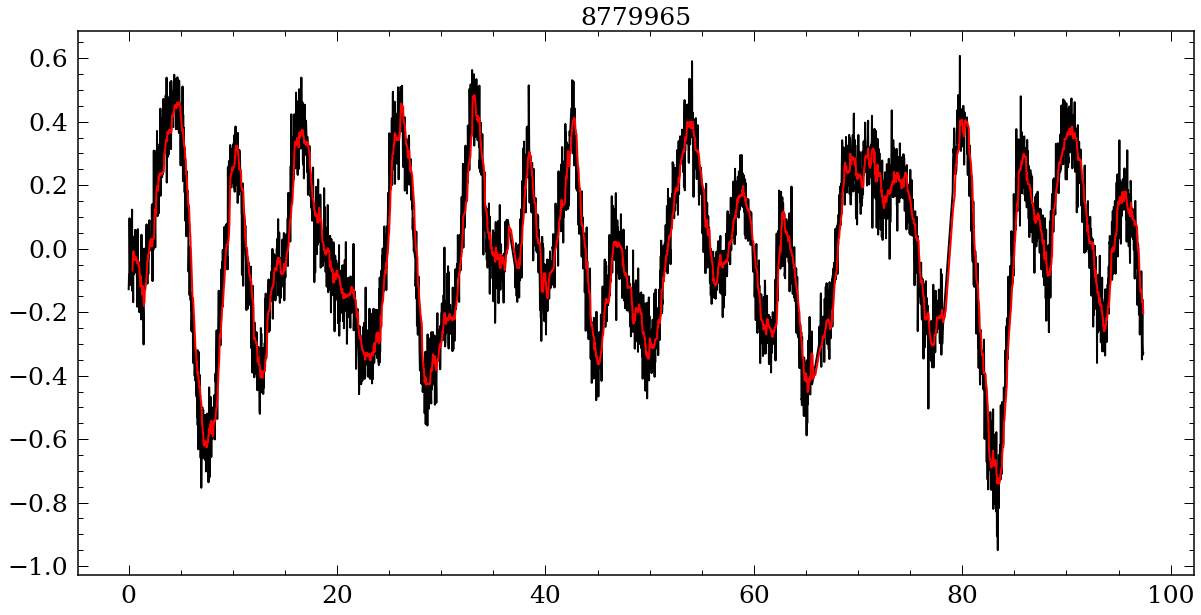

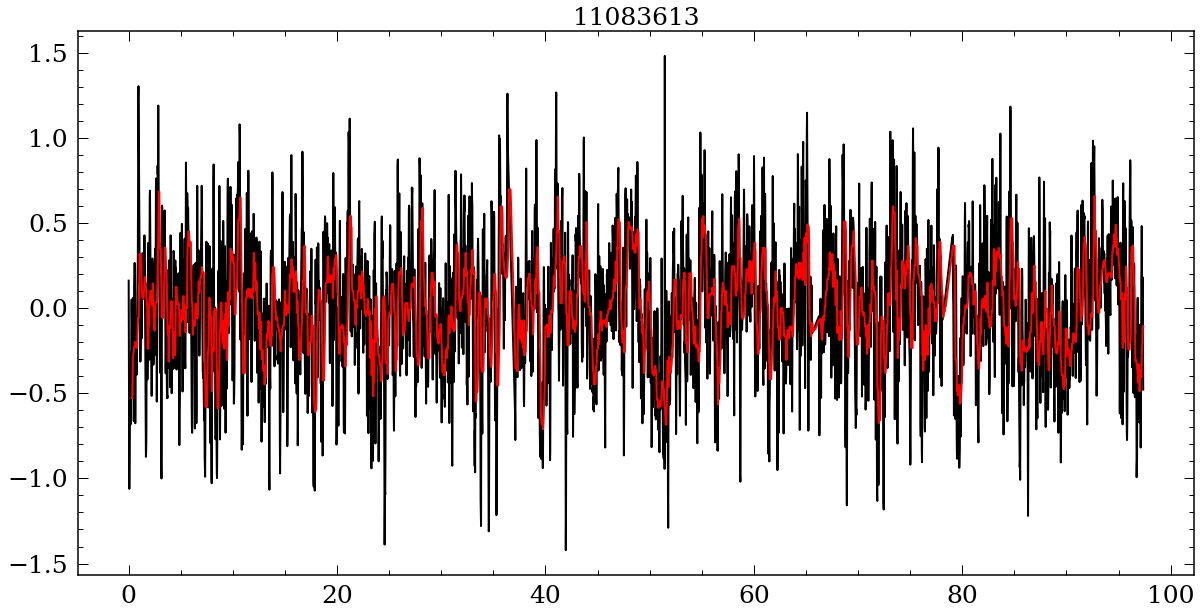

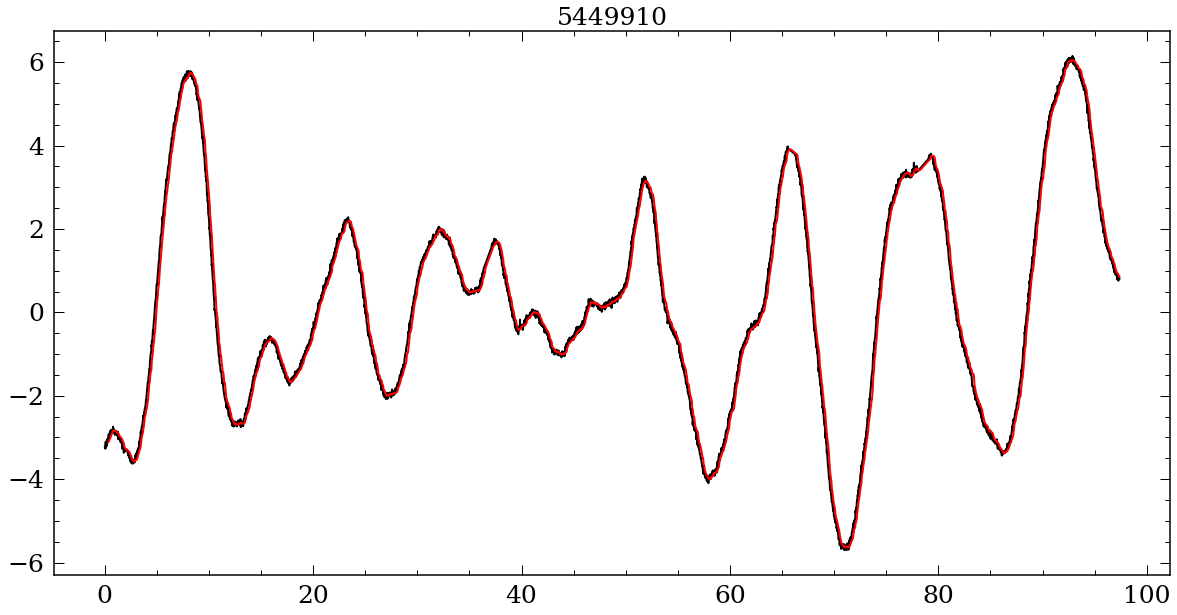

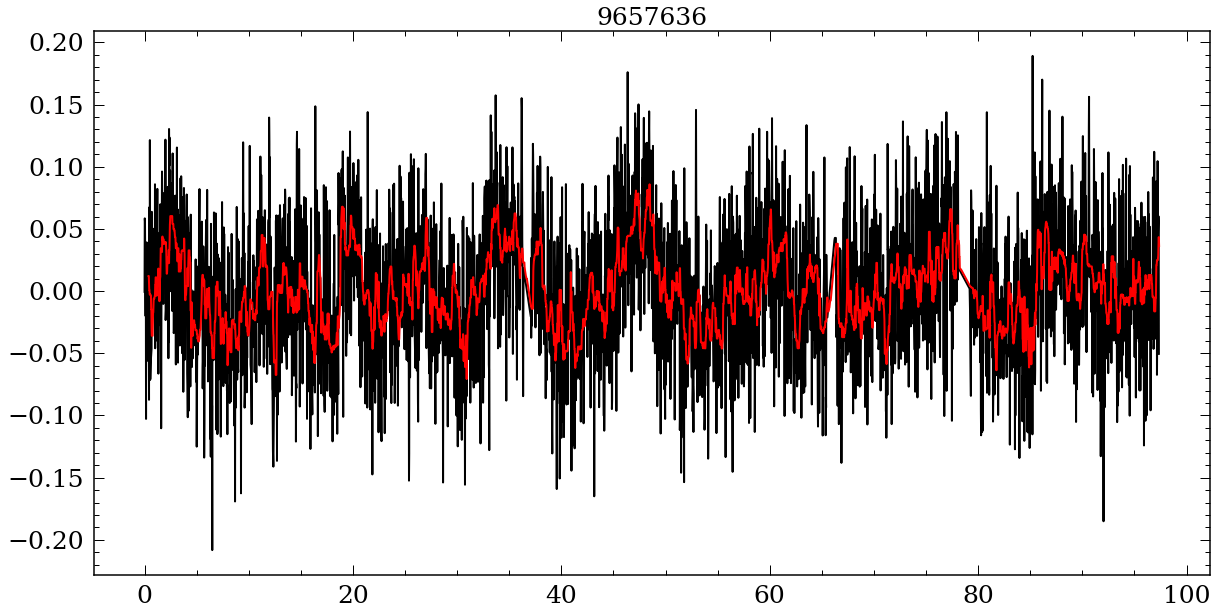

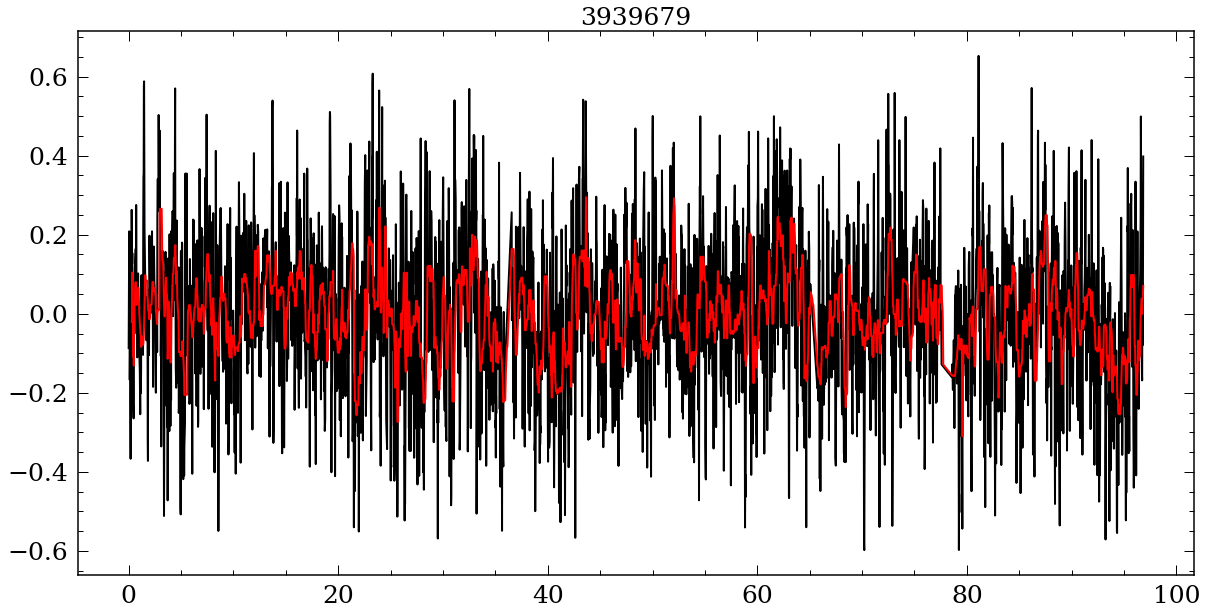

In [552]:
quart=9
flick=np.zeros(len(KID_sort_paper_flic))
flick_cor=np.zeros(len(KID_sort_paper_flic))
kmag=[11.623,11.730,11.629,11.235,11.253,11.099]
for i in range(len(KID_sort_paper_flic)):
    if KID_sort_paper_flic[i]==5449910:
        flick_cor[i],flick[i]=CalcFlicker(flux_paper_flic[i][8],time_paper_flic[i][8],kmag[i],KID_sort_paper_flic[i])
    else:
        flick_cor[i],flick[i]=CalcFlicker(flux_paper_flic[i][quart],time_paper_flic[i][quart],kmag[i],KID_sort_paper_flic[i])
print('KID',KID_sort_paper_flic)
Fp_paper=[0.055,0.067,0.284,0.046,0.049,0.171]
print('F_8',flick)
print('F_8 from paper',Fp_paper)
print('¯\_(ツ)_/¯')

# Test multiple times

In [285]:
testtime=200
# with Rper
TrainF=np.load('TrainingFeatures.npy')
df_wlc=df_wlc.reset_index(drop=True)
Chisq=np.zeros([testtime,3])
chisq_a=np.zeros(3)
chisq_std=np.zeros(3)
print(np.shape(Chisq))
for i in range(testtime):
    update_progress(i / testtime)
    Chisq[i,0]=my_randF_SL(df_wlc,0.8,TrainF,chisq_out=1)

Progress: [####################] 99.5%
regr,importance,actrualF,predictp,X_test,y_test,y_test_err,avstedv = my_randF_SL(df,traind,testF,chisq_out=0)

Fraction of data used to train: 0.8
# Features used to train: 9
Features used to train: ['Rper' 'teff' 'bp_g' 'lum_val' 'v_tan' 'phot_g_mean_flux_over_error'
 'v_b' 'radius_val' 'b']
632 stars in dataframe!
Missing 46 stars from null values in data!

586 total stars used for RF!
468 training stars!
Average Chisq is: [1519.25227274]
Finished!


In [286]:
# with Rvar_27
TrainF=np.load('TrainingFeatures.npy')
TrainF=[i for i in TrainF if i!='Rper']
TrainF.append('Rvar_27')
for i in range(testtime):
    update_progress(i / testtime)
    Chisq[i,1]=my_randF_SL(df_wlc,0.8,TrainF,chisq_out=1)

Progress: [####################] 99.5%
regr,importance,actrualF,predictp,X_test,y_test,y_test_err,avstedv = my_randF_SL(df,traind,testF,chisq_out=0)

Fraction of data used to train: 0.8
# Features used to train: 9
Features used to train: ['teff', 'bp_g', 'lum_val', 'v_tan', 'phot_g_mean_flux_over_error', 'v_b', 'radius_val', 'b', 'Rvar_27']
632 stars in dataframe!
Missing 46 stars from null values in data!

586 total stars used for RF!
468 training stars!
Average Chisq is: [1343.17474025]
Finished!


In [287]:
# with Rvar_27 and FliPers
TrainF=np.load('TrainingFeatures.npy')
TrainF=[i for i in TrainF if i!='Rper']
TrainF=np.append(TrainF,['Rvar_27'])
TrainF=np.append(TrainF,my_xticks)
for i in range(testtime):
    update_progress(i / testtime)
    Chisq[i,2]=my_randF_SL(df_wlc,0.8,TrainF,chisq_out=1)
    
for i in range(3):
    chisq_a[i]=np.mean(Chisq[:,i])
    chisq_std[i]=np.std(Chisq[:,i])


Progress: [####################] 99.5%
regr,importance,actrualF,predictp,X_test,y_test,y_test_err,avstedv = my_randF_SL(df,traind,testF,chisq_out=0)

Fraction of data used to train: 0.8
# Features used to train: 14
Features used to train: ['teff' 'bp_g' 'lum_val' 'v_tan' 'phot_g_mean_flux_over_error' 'v_b'
 'radius_val' 'b' 'Rvar_27' 'Fp02' 'Fp07' 'Fp7' 'Fp20' 'Fp50']
632 stars in dataframe!
Missing 46 stars from null values in data!

586 total stars used for RF!
468 training stars!
Average Chisq is: [1266.10646629]
Finished!


Text(0, 0.5, 'Average $\\chi^2$')

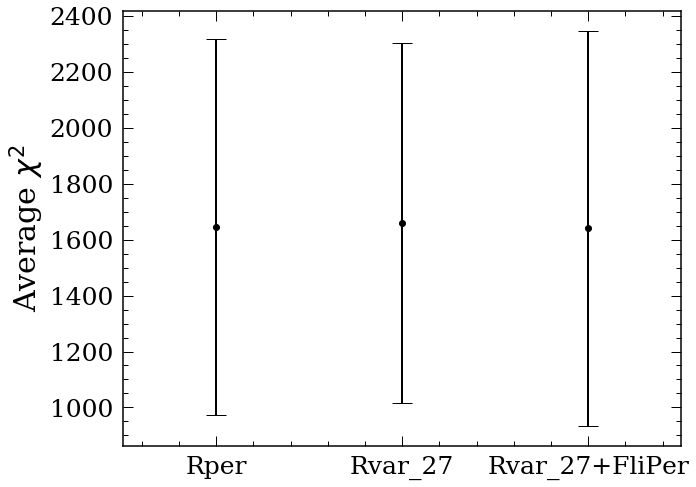

In [288]:
plt.figure(figsize=(10,8))
my_xticks_flip=['Rper','Rvar_27','Rvar_27+FliPer']
plt.errorbar(range(3),chisq_a,yerr=chisq_std,fmt='ko',barsabove=True,capsize=10)
plt.xticks(range(3), my_xticks_flip)
plt.xlim([-0.5,2.5])
plt.ylabel('Average $\chi^2$')

Not enough lc's to figure out what's better...